# 0 Imports

In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sns

import datetime
import warnings
import inflection

from datetime             import datetime
from matplotlib           import pyplot as plt
from matplotlib.gridspec  import GridSpec
from IPython.display      import Image
from IPython.core.display import HTML

from sklearn.cluster     import KMeans
from yellowbrick.cluster import KElbowVisualizer

warnings.filterwarnings( 'ignore' )

## 0.1 Funções auxiliares

In [2]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [14, 5]
    plt.rcParams['font.size'] = 18
    sns.set_palette("Reds") 
    
    display(HTML( '<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

## 0.2 Carregamento dos dados

In [4]:
df_raw = pd.read_csv('../inputs/data.csv', encoding= 'unicode_escape')

In [5]:
df_raw.sample(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
302479,563432,23300,GARDENERS KNEELING PAD CUP OF TEA,3,8/16/2011 12:12,1.65,16713.0,United Kingdom
246432,558700,21243,PINK POLKADOT PLATE,1,7/1/2011 12:33,1.69,17920.0,United Kingdom
237605,C557876,23245,SET OF 3 REGENCY CAKE TINS,-1,6/23/2011 13:10,4.95,18223.0,United Kingdom
185395,552815,22847,BREAD BIN DINER STYLE IVORY,1,5/11/2011 12:46,16.95,17677.0,United Kingdom
369425,569028,23350,ROLL WRAP VINTAGE SPOT,12,9/30/2011 10:20,1.25,14911.0,EIRE
82039,C543185,22332,SKULLS PARTY BAG + STICKER SET,-14,2/4/2011 11:22,1.65,NaN,United Kingdom
189319,553148,47599A,PINK PARTY BAGS,6,5/13/2011 14:09,2.10,NaN,Hong Kong
140811,548468,84625C,BLUE NEW BAROQUE CANDLESTICK CANDLE,2,3/31/2011 12:28,2.95,14818.0,United Kingdom
119533,546549,22055,MINI CAKE STAND HANGING STRAWBERY,2,3/14/2011 16:46,1.65,17799.0,United Kingdom
424248,573248,22867,HAND WARMER BIRD DESIGN,2,10/28/2011 12:09,2.10,14498.0,United Kingdom


# 1 Descrição dos dados

In [6]:
df1 = df_raw.copy()

## 1.1 Renomeando colunas

In [7]:
snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, df1.columns))

#rename
df1.columns = cols_new

## 1.2 Dimensão dos dados

In [8]:
print('Núm de Linhas: {}'.format(df1.shape[0]))
print('Núm de Colunas: {}'.format(df1.shape[1]))

Núm de Linhas: 541909
Núm de Colunas: 8


## 1.3 Tipo dos dados

In [9]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Checagem de valores nulos

In [10]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Preenchimento de nulos

In [11]:
df1 = df1.dropna(subset=['description', 'customer_id'])
print('Percentual de dados removidos: {:.2f}%'.format((1 - (df1.shape[0] / df_raw.shape[0]))*100))

Percentual de dados removidos: 24.93%


## 1.6 Mudando tipo dos dados

In [12]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], infer_datetime_format=True).dt.date.astype('datetime64')

# customer_id 
df1['customer_id'] = df1['customer_id'].astype('int64').astype('object')

In [13]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id             object
country                 object
dtype: object

## 1.7 Análise descritiva

In [ ]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [ ]:
num_attributes.columns

In [ ]:
cat_attributes.columns

### 1.7.1 Atributos númericos

In [ ]:
# Central Tendency - mean, mediana, 25%, 75% // dispersion - std, min, max, 
ctd1 = num_attributes.describe()

#dispersion - range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d2 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d3 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#join
medidas = pd.concat([ctd1, d1, d2, d3]).T.reset_index()
medidas.columns = ['attributes', 'count','mean', 'std', 'min', '25%', 'median', '75%', 'max', 'range', 'skew', 'kurtosis']


medidas

In [ ]:
plt.figure(figsize = (30,60))
num_attributes.hist(bins= 25, color= 'indianred');

### 1.7.2 Atributos categóricos

In [ ]:
cat_attributes.apply(lambda x: x.unique().shape[0])

# 2 Feature engineering

In [14]:
df2 = df1.copy()

## 2.1 Mapa Mental de hipóteses

In [ ]:
Image("../images/")

## 2.2 Criação das hipóteses

## 2.3 Lista final de hipóteses

## 2.4 Criação de novas variáveis

In [15]:
# df de referência 
df_ref = df2[['customer_id']].drop_duplicates(ignore_index=True)

# revenue = quantity * price
df2['revenue'] = df2['quantity'] * df2['unit_price']

# monetary
df_monetary = df2.groupby('customer_id')['revenue'].sum().reset_index()

# recency
df_recency = df2.groupby('customer_id')['invoice_date'].max().reset_index()
df_recency['recency_days'] = (df2['invoice_date'].max() - df_recency['invoice_date']).dt.days

# frequency
df_frequency = df2.groupby('customer_id')['invoice_no'].nunique().reset_index()

# join
c_id = 'customer_id'
df_ref = df_ref.merge(df_monetary, on=c_id, how='left').merge(df_recency, on=c_id, how='left').merge(df_frequency, on=c_id, how='left')

In [16]:
df_ref.head().T

,0,1,2,3,4
customer_id,17850,13047,12583,13748,15100
revenue,5288.63,3079.1,7187.34,948.25,635.1
invoice_date,2011-02-10 00:00:00,2011-11-08 00:00:00,2011-12-07 00:00:00,2011-09-05 00:00:00,2011-01-13 00:00:00
recency_days,302,31,2,95,330
invoice_no,35,18,18,5,6


# 3 Filtragem dos dados

In [17]:
df3 = df_ref.copy()

## 3.1 Filtragem das linhas

## 3.2 Filtragem das colunas

# 4. Análise exploratória de dados (EDA)

In [18]:
df4 = df3.copy()

In [ ]:
num_attributes = df4.select_dtypes(include=['int64', 'float64'])
cat_attributes = df4.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

## 4.1 Análise univariada

### 4.1.1 Variável resposta

### 4.1.2 Variáveis numéricas

### 4.1.3 Variável categóricas

## 4.2 Análise bivariada

### Hn: 
**VERDADEIRA/FALSA**

### 4.2.1 Resumo das hipóteses

In [ ]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Falsa', 'Baixa'],  
      ['H2', 'Falsa', 'Media'],  
      ['H3', 'Falsa', 'Media'],
      ['H4', 'Falsa', 'Baixa'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Baixa'],
      ['H7', 'Falsa', 'Media'],
      ['H8', 'Falsa', 'Alta'],
      ['H9', 'Falsa', 'Alta'],
      ['H10', 'Verdadeira', 'Alta'],
      ['H11', 'Verdadeira', 'Alta'],
      ['H12', 'Verdadeira', 'Baixa'],
     ]  
print(tabulate( tab, headers='firstrow'))

## 4.3 Análise multivariada

### 4.3.1 Variáveis númericas

### 4.3.2 Variáveis categóricas

# 5 Preparação dos dados

In [19]:
df5 = df4.copy()

## 5.1 Normalização

## 5.2 Rescaling

## 5.3 Transformação

### 5.3.1 Encoding

### 5.3.2 Transformação da variável resposta

### 5.3.3 Transformação de natureza

# 6 Seleção de variáveis

In [20]:
df6 = df5.copy()

## 6.1 Separação do conjunto de dados em treino e teste

## 6.2 Feature selector

## 6.3 Seleção de variáveis manual após feature selector

# 7 Otimização dos hiperparâmetros

In [21]:
df7 = df6.copy()

In [22]:
X = df7[['revenue', 'recency_days', 'invoice_no']]

In [23]:
clusters = [2, 3, 4, 5, 6]

## 7.1 Within-Cluster Sum of Square (WSS)

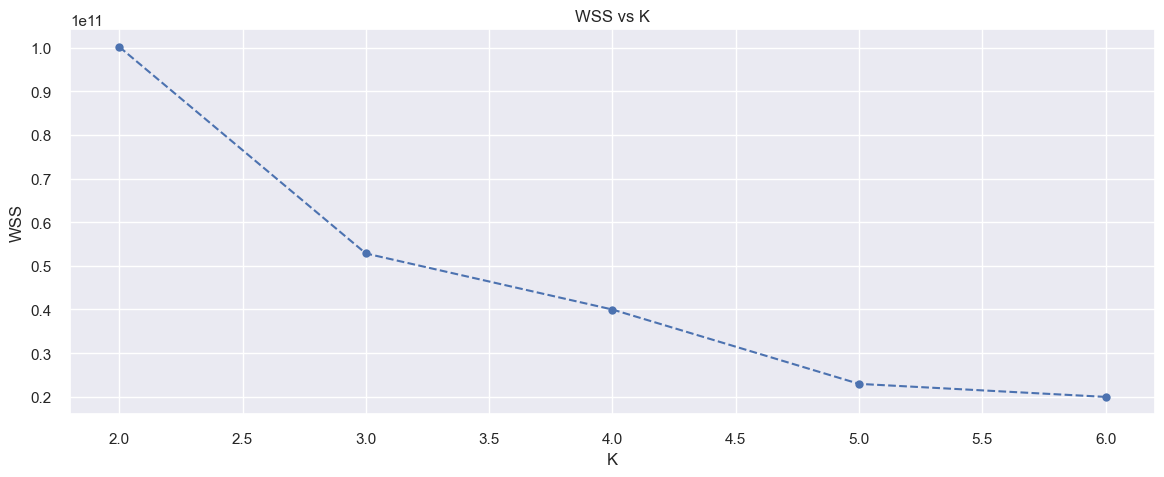

In [24]:
wss = []
for k in clusters:
    #model definition
    kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)
    
    #model training
    kmeans.fit(X)
    
    #validation
    wss.append(kmeans.inertia_)
    
plt.plot(clusters, wss, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('WSS')
plt.title('WSS vs K')
plt.show()

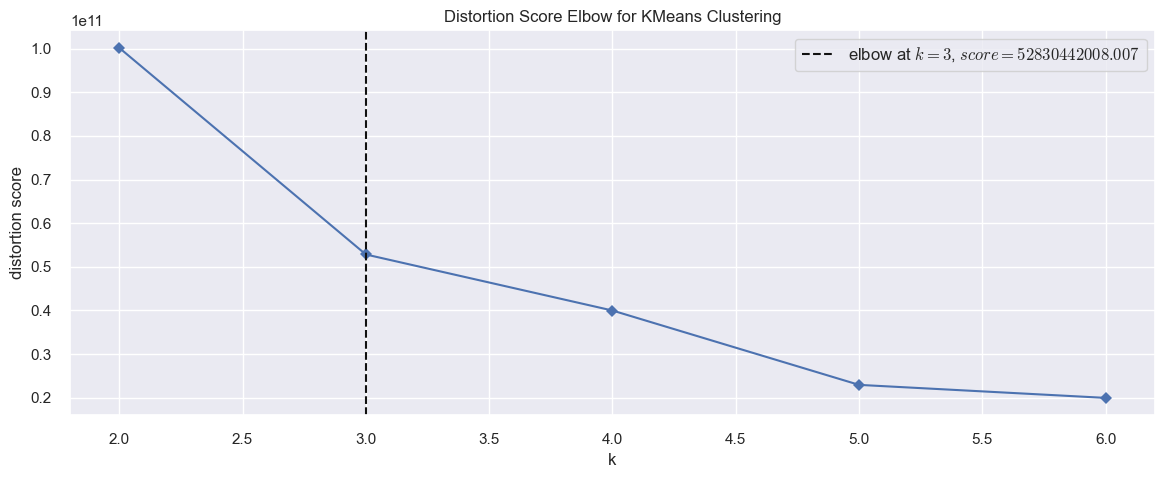

In [26]:
kmeans = KElbowVisualizer(KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();

## 7.2 Silhouette Score

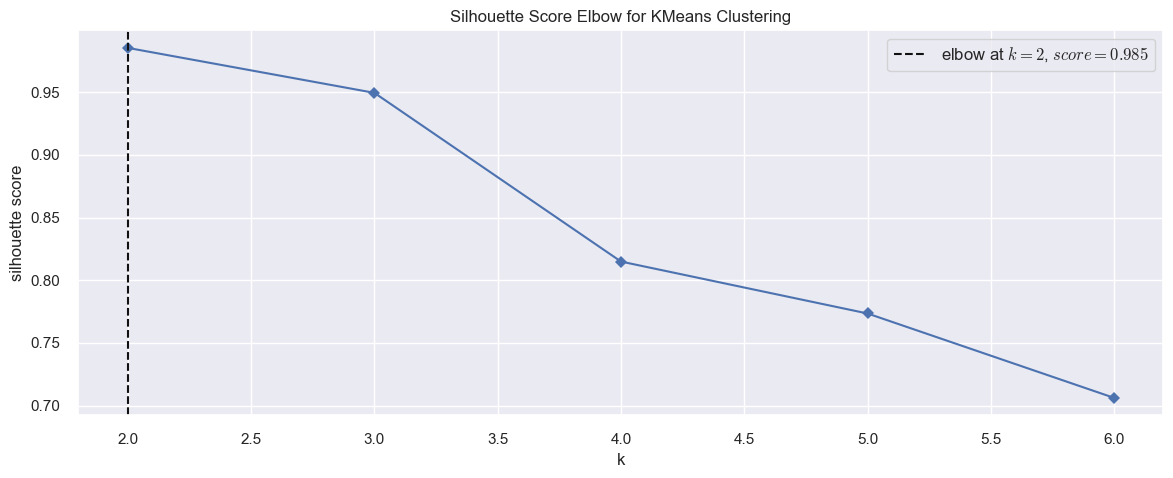

In [27]:
kmeans = KElbowVisualizer(KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42), k=clusters, metric='silhouette',timings=False)
kmeans.fit(X)
kmeans.show();

# 8 Machine learning

## 8.1 Método otimizador

## 8.2 Modelo final tunado

Tempo de execução: 1h09

# 9 Análise dos clusters

## 9.1 Performance do negócio

# 10 Deployment do modelo em produção

In [ ]:
# Save Trained Model


## 10.1 Model class

## 10.2 API handler

## 10.3 API tester